In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil

In [ ]:
!nvidia-smi

Tue May 17 12:19:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz

--2022-05-17 12:19:21--  https://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4273561758 (4.0G) [application/octet-stream]
Saving to: ‘BreaKHis_v1.tar.gz’

BreaKHis_v1.tar.gz  100%[===================>]   3.98G  14.0MB/s    in 5m 5s   

2022-05-17 12:24:27 (13.4 MB/s) - ‘BreaKHis_v1.tar.gz’ saved [4273561758/4273561758]



In [ ]:
os.makedirs('/content/output/')
os.makedirs('/content/dataset/')

os.makedirs('/content/dataset/benign/')
os.makedirs('/content/dataset/malignant/')

In [ ]:
!tar -xzvf "/content/BreaKHis_v1.tar.gz" -C "/content/output/"

In [ ]:
mali_path= '/content/output/BreaKHis_v1/histology_slides/breast/malignant/'
ben_path= '/content/output/BreaKHis_v1/histology_slides/breast/benign/'

for dirname, _, filenames in os.walk(ben_path):
  for filename in filenames:
    i= filename.split('.')
    if i[-1] =='png':
      original= os.path.join(dirname, filename)
      target= os.path.join('/content/dataset/benign/', filename)
      shutil.copyfile(original, target)

for dirname, _, filenames in os.walk(mali_path):
  for filename in filenames:
    i= filename.split('.')
    if i[-1] =='png':
      original= os.path.join(dirname, filename)
      target= os.path.join('/content/dataset/malignant/', filename)
      shutil.copyfile(original, target)

In [ ]:
!pip install timm

In [ ]:
import torch
from torch import nn, optim
import timm

In [ ]:
timm.list_models('mobilevit_xs',pretrained=True)

[]

In [ ]:
import torchvision
from torchvision import datasets, transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from sklearn.metrics import f1_score, confusion_matrix , classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
torchvision.__version__, torch.__version__ # ('0.11.1+cu111', '1.10.0+cu111')

('0.12.0+cu113', '1.11.0+cu113')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomApply(transforms=[
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
            ], p=0.2),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        all_data = datasets.ImageFolder(data_dir, transform=transform)
        train_data_len = int(len(all_data)*0.75)
        valid_data_len = int((len(all_data) - train_data_len)/2)
        test_data_len = int(len(all_data) - train_data_len - valid_data_len)
        train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, train_data_len
    
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        all_data = datasets.ImageFolder(data_dir, transform=transform)
        train_data_len = int(len(all_data)*0.70)
        valid_data_len = int((len(all_data) - train_data_len)/2)
        test_data_len = int(len(all_data) - train_data_len - valid_data_len)
        train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return (val_loader, test_loader, valid_data_len, test_data_len)

In [ ]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [ ]:
data= '/content/dataset/'

In [ ]:
(train_loader, train_data_len) = get_data_loaders(data, 64, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(data , 64, train=False)
classes = get_classes(data)

In [ ]:
print(len(classes))

2


In [ ]:
dataloaders = {
    "train":train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train":train_data_len,
    "val": valid_data_len
}

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))
print(train_data_len, test_data_len, valid_data_len)

93
19
19
5931 1187 1186


In [ ]:
 #model =torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
model =timm.create_model('deit_tiny_patch16_224',pretrained=True)

Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth


In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs,512),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
print(model.head)

Sequential(
  (0): Linear(in_features=192, out_features=512, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
)


In [ ]:
inp = torch.randn(1, 3, 224, 224)
model(inp).shape

torch.Size([1, 2])

In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [ ]:
print_size_of_model(model)

Size (MB): 22.549389


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

device(type='cuda')

In [ ]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)

In [ ]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [ ]:
from tqdm import tqdm
import time
import copy

In [ ]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.7)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def test(model):
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  model.eval()

  for data, target in tqdm(test_loader):
      if torch.cuda.is_available(): 
          data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      if len(target) == 64:
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [ ]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


100%|██████████| 93/93 [01:50<00:00,  1.19s/it]


train Loss: 0.3874 Acc: 0.8341


100%|██████████| 19/19 [00:15<00:00,  1.19it/s]


val Loss: 0.2980 Acc: 0.8853

Epoch 1/19
----------


100%|██████████| 93/93 [01:47<00:00,  1.16s/it]


train Loss: 0.3082 Acc: 0.8767


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


val Loss: 0.2608 Acc: 0.8980

Epoch 2/19
----------


100%|██████████| 93/93 [01:46<00:00,  1.14s/it]


train Loss: 0.2745 Acc: 0.8891


100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


val Loss: 0.2450 Acc: 0.9056

Epoch 3/19
----------


100%|██████████| 93/93 [01:45<00:00,  1.14s/it]


train Loss: 0.2458 Acc: 0.9012


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


val Loss: 0.2237 Acc: 0.9140

Epoch 4/19
----------


100%|██████████| 93/93 [01:45<00:00,  1.13s/it]


train Loss: 0.2176 Acc: 0.9157


100%|██████████| 19/19 [00:15<00:00,  1.23it/s]


val Loss: 0.2012 Acc: 0.9275

Epoch 5/19
----------


100%|██████████| 93/93 [01:45<00:00,  1.14s/it]


train Loss: 0.2016 Acc: 0.9223


100%|██████████| 19/19 [00:15<00:00,  1.23it/s]


val Loss: 0.1676 Acc: 0.9342

Epoch 6/19
----------


100%|██████████| 93/93 [01:43<00:00,  1.11s/it]


train Loss: 0.1889 Acc: 0.9260


100%|██████████| 19/19 [00:15<00:00,  1.23it/s]


val Loss: 0.1849 Acc: 0.9283

Epoch 7/19
----------


100%|██████████| 93/93 [01:44<00:00,  1.12s/it]


train Loss: 0.1790 Acc: 0.9310


100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


val Loss: 0.1599 Acc: 0.9427

Epoch 8/19
----------


100%|██████████| 93/93 [01:44<00:00,  1.12s/it]


train Loss: 0.1632 Acc: 0.9374


100%|██████████| 19/19 [00:15<00:00,  1.23it/s]


val Loss: 0.1436 Acc: 0.9545

Epoch 9/19
----------


100%|██████████| 93/93 [01:47<00:00,  1.15s/it]


train Loss: 0.1514 Acc: 0.9403


100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


val Loss: 0.1510 Acc: 0.9477

Epoch 10/19
----------


100%|██████████| 93/93 [01:44<00:00,  1.12s/it]


train Loss: 0.1512 Acc: 0.9425


100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


val Loss: 0.1383 Acc: 0.9519

Epoch 11/19
----------


100%|██████████| 93/93 [01:44<00:00,  1.13s/it]


train Loss: 0.1442 Acc: 0.9472


100%|██████████| 19/19 [00:16<00:00,  1.18it/s]


val Loss: 0.1229 Acc: 0.9578

Epoch 12/19
----------


100%|██████████| 93/93 [01:47<00:00,  1.15s/it]


train Loss: 0.1355 Acc: 0.9508


100%|██████████| 19/19 [00:15<00:00,  1.19it/s]


val Loss: 0.1231 Acc: 0.9587

Epoch 13/19
----------


100%|██████████| 93/93 [01:48<00:00,  1.17s/it]


train Loss: 0.1246 Acc: 0.9552


100%|██████████| 19/19 [00:16<00:00,  1.19it/s]


val Loss: 0.1200 Acc: 0.9587

Epoch 14/19
----------


100%|██████████| 93/93 [01:44<00:00,  1.13s/it]


train Loss: 0.1228 Acc: 0.9526


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


val Loss: 0.1125 Acc: 0.9621

Epoch 15/19
----------


100%|██████████| 93/93 [01:47<00:00,  1.16s/it]


train Loss: 0.1109 Acc: 0.9604


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


val Loss: 0.1149 Acc: 0.9612

Epoch 16/19
----------


100%|██████████| 93/93 [01:46<00:00,  1.15s/it]


train Loss: 0.1184 Acc: 0.9553


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


val Loss: 0.1095 Acc: 0.9637

Epoch 17/19
----------


100%|██████████| 93/93 [01:44<00:00,  1.13s/it]


train Loss: 0.1134 Acc: 0.9609


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


val Loss: 0.1071 Acc: 0.9654

Epoch 18/19
----------


100%|██████████| 93/93 [01:45<00:00,  1.14s/it]


train Loss: 0.1059 Acc: 0.9621


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


val Loss: 0.1041 Acc: 0.9646

Epoch 19/19
----------


100%|██████████| 93/93 [01:44<00:00,  1.12s/it]


train Loss: 0.1035 Acc: 0.9641


100%|██████████| 19/19 [00:15<00:00,  1.22it/s]

val Loss: 0.1086 Acc: 0.9578

Training complete in 40m 34s
Best val Acc: 0.965430


In [ ]:
def plot_loss(training_history,validation_history,EPOCHS):
    acc = []
    val_acc = []
    for i in  training_history['accuracy']:
        acc.append(i.cpu().numpy())
    for i in  validation_history['accuracy']:
        val_acc.append(i.cpu().numpy())
    loss =  training_history['loss']
    val_loss = validation_history['loss']
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

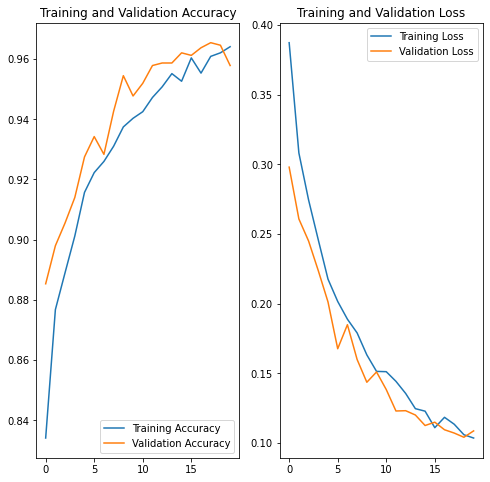

In [ ]:
plot_loss(training_history,validation_history,20)

In [ ]:
test(model_ft)

100%|██████████| 19/19 [00:15<00:00,  1.20it/s]

Test Loss: 0.112623

Test Accuracy of benign: 96% (370/382)
Test Accuracy of malignant: 97% (747/770)

Test Accuracy (Overall): 96.9618 (1117.0/1152.0)


In [ ]:
def plot_onfusion_matrix(model):
    y_pred = []
    y_true = []
    model.eval()
    for data, target in tqdm(test_loader):
        y_true = y_true + target.tolist()
        if torch.cuda.is_available(): 
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            output = model(data)
            loss = criterion(output, target)
            _, pred = torch.max(output, 1)
            y_pred = y_pred + pred.tolist()
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap = 'Blues')
    plt.title('Confusion matrix - ')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print(classification_report(y_true, y_pred))
    print("Micro F1: {:.4f}".format(f1_score(y_true, y_pred, average='micro') * 100))
    print("Macro F1: {:.4f}".format(f1_score(y_true, y_pred, average='macro') * 100))
    print("Weighted F1: {:.4f}".format(f1_score(y_true, y_pred, average='weighted') * 100))

100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


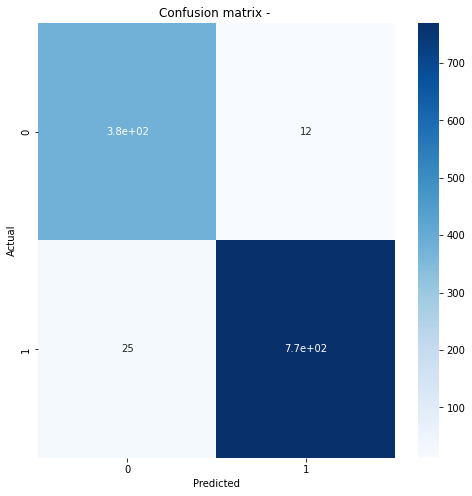

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       392
           1       0.98      0.97      0.98       795

    accuracy                           0.97      1187
   macro avg       0.96      0.97      0.97      1187
weighted avg       0.97      0.97      0.97      1187

Micro F1: 96.8829
Macro F1: 96.5057
Weighted F1: 96.8955


In [ ]:
plot_onfusion_matrix(model_ft)